In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge,LinearRegression

Using TensorFlow backend.


In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test_id = test['Id'] # Used during Submission of problem.

In [4]:
train['File'] = 'Train' # indicator where the record comes from 
test['File'] = 'Test' 

test.drop(columns = 'Id', inplace = True) # dropping ID columns / not relevant to training
train.drop(columns = 'Id', inplace = True)

In [5]:
test['SalePrice'] = 0 # dummy value for concatenation

## EDA

In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,File
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,Train
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,Train
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,Train
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,Train
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,Train


In [7]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,File,SalePrice
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,...,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,Test,0
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,...,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,Test,0
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,...,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,Test,0
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,...,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,Test,0
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,...,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,Test,0


### Univariate analysis on Target Variable

In [8]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

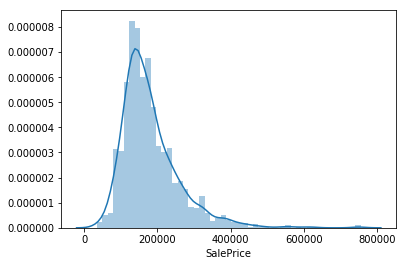

In [9]:
#Distribution
sns.distplot(train['SalePrice']);

In [10]:
print(f"Skewness:{train['SalePrice'].skew()}")
print(f"Kurtosis:{train['SalePrice'].kurt()}")

Skewness:1.8828757597682129
Kurtosis:6.536281860064529


Positively Skewed  
Shows peakedness :  Leptokurtic

### Multivariate analysis

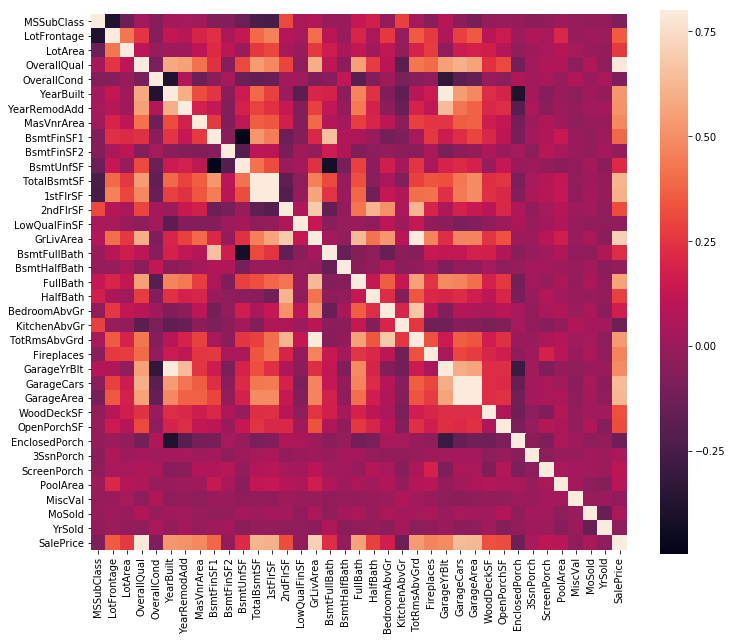

In [11]:
correlation_matrix = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, vmax=.8, square=True)
plt.show()

In [12]:
# Considering only top 10 variables , with highest correlation with Target Variable.
cols_10 = correlation_matrix.nlargest(10,'SalePrice').index
cols_10 = list(cols_10)

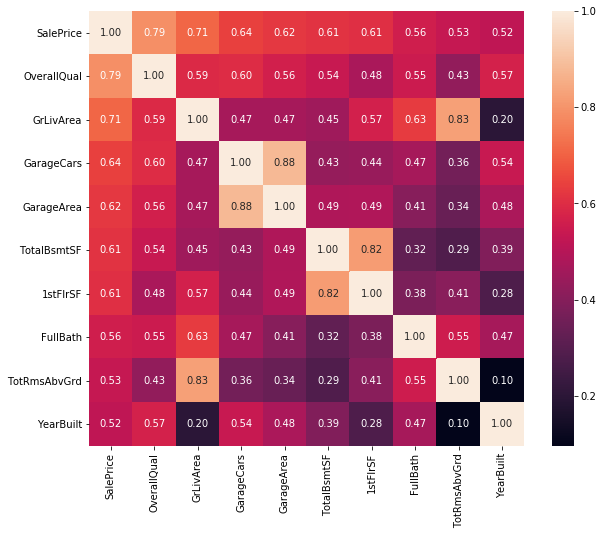

In [13]:
cm10 = correlation_matrix.loc[cols_10,cols_10]
plt.figure(figsize=(10,8))
sns.heatmap(cm10,annot=True,fmt = '.2f',square=True)
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


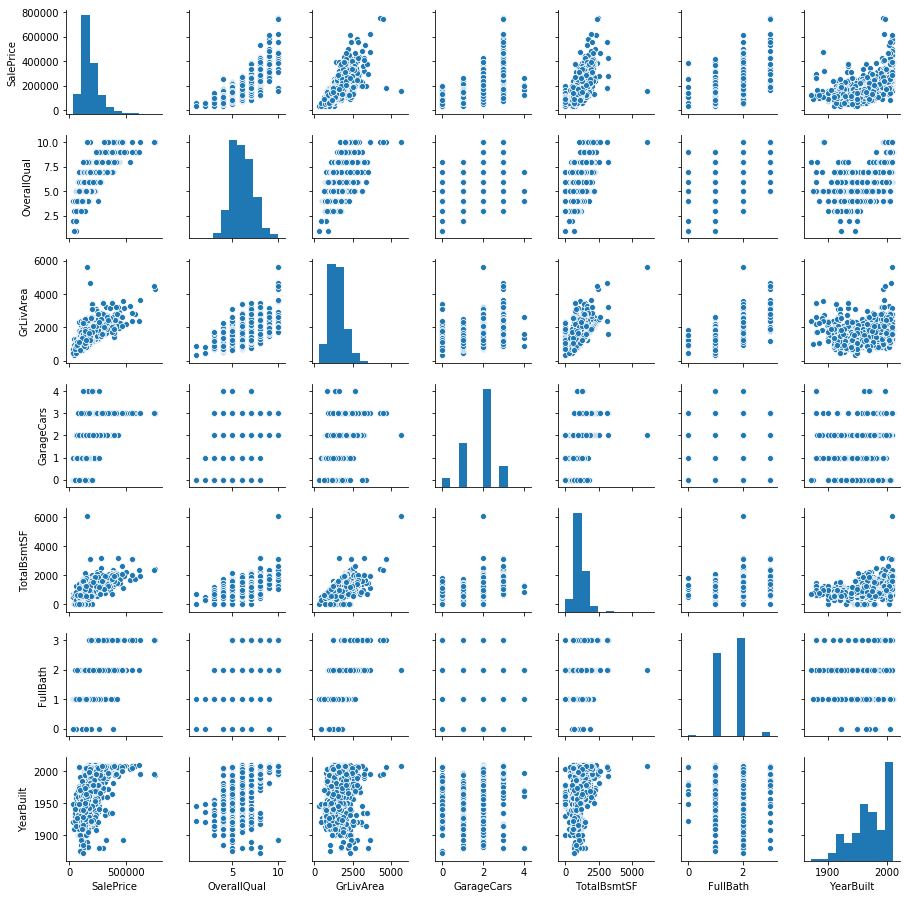

In [14]:
#Cols with less correlation among them
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 1.8)
plt.show()

We find linear and exponential-like relation

# Data Cleaning


In [15]:
# Combining dataset for combined cleaning
data = train.append(test,sort=False)
data.shape

(2919, 81)

In [16]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(34)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageQual,159,0.054471
GarageCond,159,0.054471
GarageFinish,159,0.054471
GarageYrBlt,159,0.054471


* 'PoolQC', 'MiscFeature', 'Alley' are missing more than 90% values, and not some strong cadidate to affect SalePrice, so we'll drop them but first see their boxplots.
* 'GarageX' variables are also missing more than 50 % , and most of their significance could be handles using 'GarageCars'
* Similarly for BsmtX variables with more than 2 % values missing.
* 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. 

             LotFrontage   LotArea
LotFrontage     1.000000  0.489896
LotArea         0.489896  1.000000


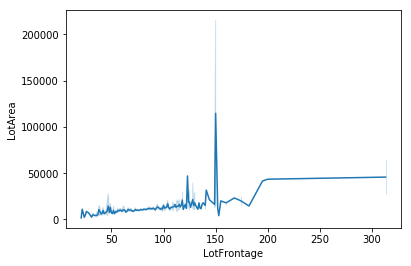

In [17]:
# Regarding LotFrontage
print(data[['LotFrontage','LotArea']].corr())
sns.lineplot('LotFrontage','LotArea',data=data)
plt.show()

Considering number of missing values , and its relationship with LotArea, we'll drop it.

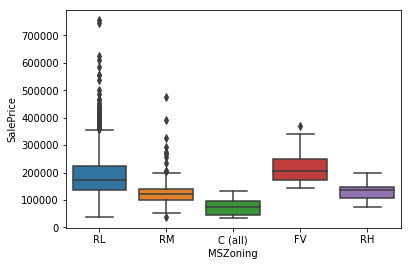

In [18]:
# Regarding MSZoning
sns.boxplot('MSZoning','SalePrice',data = train)
# used data = train, because, test set has no values for 'SalePrice'


We should impute mising 'MSZoning' with 'RL'

In [19]:
data['MSZoning'].replace(np.nan,"RL",inplace=True)

In [20]:
# Regarding 'PoolQC', 'MiscFeature', 'Alley'
data['PoolQC'].replace(np.nan,"None",inplace = True)
data['FireplaceQu'].replace(np.nan,"None",inplace = True)
data['Alley'].replace(np.nan,"None",inplace = True)

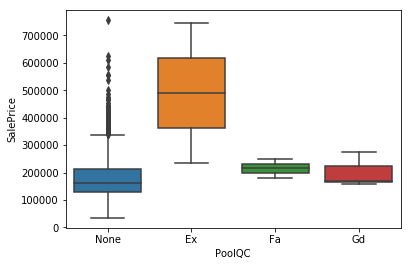

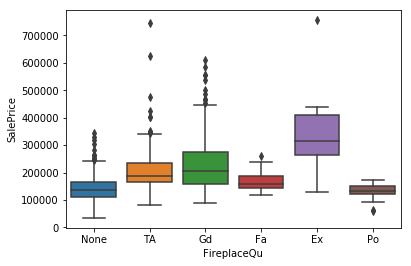

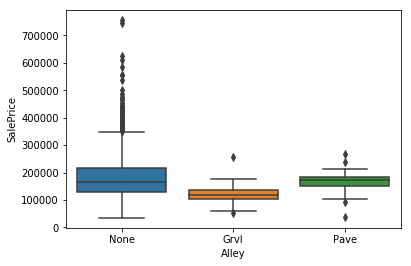

In [21]:
sns.boxplot('PoolQC','SalePrice',data = data[:1460])
plt.show()
sns.boxplot('FireplaceQu','SalePrice',data = data[:1460])
plt.show()
sns.boxplot('Alley','SalePrice',data = data[:1460])
plt.show()

Considering the number of Outliers and missing values also, we are discarding these variables

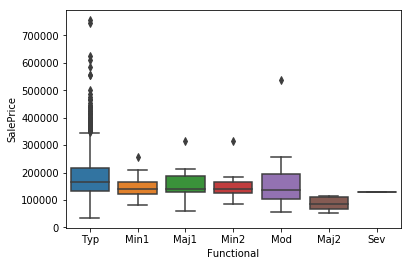

In [22]:
sns.boxplot('Functional','SalePrice',data = data[:1460])
plt.show()
# Since only 2 values are missing , we'll impute it using MAX -> 'Typ'

In [25]:
data['Functional'].replace(np.nan,'Typ',inplace=True)

In [26]:
# Removed Variables till 'MasVnrArea'
data = data.drop((missing_data[missing_data['Total'] > 4]).index,axis=1)

KeyError: "['PoolQC' 'MiscFeature' 'Alley' 'Fence' 'FireplaceQu' 'LotFrontage'\n 'GarageQual' 'GarageCond' 'GarageFinish' 'GarageYrBlt' 'GarageType'\n 'BsmtExposure' 'BsmtCond' 'BsmtQual' 'BsmtFinType2' 'BsmtFinType1'\n 'MasVnrType' 'MasVnrArea'] not found in axis"

#### Final Imputation


In [27]:
rem_misng_cols = list(missing_data.index[19:34])
rem_misng_cols

['BsmtFullBath',
 'BsmtHalfBath',
 'Functional',
 'Utilities',
 'GarageCars',
 'Electrical',
 'SaleType',
 'KitchenQual',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Exterior2nd',
 'Exterior1st',
 'GarageArea']

In [28]:
# Catergorical columns
data['Exterior1st'].replace(np.nan,"VinylSd",inplace=True) 
data['Exterior2nd'].replace(np.nan,"VinylSd",inplace=True) 
data['Electrical'].replace(np.nan,"SBrkr",inplace=True) 
data['Utilities'].replace(np.nan,"AllPub",inplace=True) 
data['KitchenQual'].replace(np.nan,'TA',inplace=True) 
data['Functional'].replace(np.nan,'Typ',inplace=True)
data['SaleType'].replace(np.nan,'WD',inplace=True)

In [29]:
total = data.isnull().sum().sort_values(ascending=False)[:10]
total

BsmtHalfBath    2
BsmtFullBath    2
TotalBsmtSF     1
GarageCars      1
GarageArea      1
BsmtUnfSF       1
BsmtFinSF1      1
BsmtFinSF2      1
ExterQual       0
Exterior2nd     0
dtype: int64

In [30]:
data.fillna(0,inplace=True)

In [31]:
data.isnull().sum().max()

0

### Handling Categorical Values

In [32]:
datax = pd.get_dummies(data,prefix = 'D',drop_first=True)

In [33]:
datax.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,D_FV,D_RH,D_RL,D_RM,D_Pave,D_IR2,...,D_Wood,D_GasA,D_GasW,D_Grav,D_OthW,D_Wall,D_Fa,D_Gd,D_Po,D_TA,D_Y,D_FuseF,D_FuseP,D_Mix,D_SBrkr,D_Fa,D_Gd,D_TA,D_Maj2,D_Min1,D_Min2,D_Mod,D_Sev,D_Typ,D_P,D_Y,D_CWD,D_Con,D_ConLD,D_ConLI,D_ConLw,D_New,D_Oth,D_WD,D_AdjLand,D_Alloca,D_Family,D_Normal,D_Partial,D_Train
0,60,8450,7,5,2003,2003,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2.0,548.0,0,61,0,0,0,0,0,2,2008,208500,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,20,9600,6,8,1976,1976,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,2.0,460.0,298,0,0,0,0,0,0,5,2007,181500,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
2,60,11250,7,5,2001,2002,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2.0,608.0,0,42,0,0,0,0,0,9,2008,223500,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,70,9550,7,5,1915,1970,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,3.0,642.0,0,35,272,0,0,0,0,2,2006,140000,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,60,14260,8,5,2000,2000,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,3.0,836.0,192,84,0,0,0,0,0,12,2008,250000,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1


In [34]:
# Getting Train and test back
train = datax[datax['D_Train']==1]
train = train.drop(columns = ['D_Train'])

test = datax[datax['D_Train']==0]
test = test.drop(columns = ['D_Train','SalePrice'])

In [35]:
test.shape

(1459, 192)

## Using Neural Nets

In [ ]:
# Splitting our data into train and test
train

In [ ]:
reg = Sequential()
reg.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
reg.add(Dense(16,activation='relu'))
reg.add(Dense(1,activation='linear'))
reg.summary()


In [ ]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
reg.compile(loss = 'mse', optimizer = 'adam',metrics=['accuracy', r2_keras])